### RISQUE DE DÉFAUT DU CRÉDIT IMMOBILIER
La plupart des caractéristiques sont créées en appliquant les fonctions min, max, mean, sum et var à des tableaux groupés.    
Il y a peu de sélection de caractéristiques et l'ajustement excessif peut être un problème puisque de nombreuses caractéristiques sont liées.   

Les idées clés suivantes ont été utilisées :
- Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
- Dans les données du bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
- Dans les demandes précédentes : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
- Modularité : une fonction pour chaque table (sauf bureau_balance et application_test).
- Encodage unique pour les caractéristiques catégorielles

Toutes les tables sont jointes avec l'application DF en utilisant la clé SK_ID_CURR (sauf bureau_balance).
Vous pouvez utiliser LightGBM avec KFold ou KFold stratifié.


In [1]:
# import des librairies
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re

#### data engineering

In [2]:
path = 'C:/Users/tjame/OneDrive/Documents/Thomas/OpenClassRooms/P7_Meunier_Thomas/'

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - Fait en {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows, sep=',')
    test_df = pd.read_csv(path + 'application_test.csv', nrows= num_rows, sep=',')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows, sep=',')
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows, sep=',')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows, sep=',')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows, sep=',')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows, sep=',')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows, sep=',')   
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        # For don't have the LightGBMError: Do not support special JSON characters in feature name.
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [3]:
# data engineering
df = application_train_test()

bureau = bureau_and_balance()
print("Bureau shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
    
prev = previous_applications()
print("Previous applications shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')

pos = pos_cash()
print("Pos-cash balance shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')

ins = installments_payments()
print("Installments payments shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')

cc = credit_card_balance()
print("Credit card balance shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')

Train samples: 307511, test samples: 48744
Bureau shape: (305811, 116)
Previous applications shape: (338857, 249)
Pos-cash balance shape: (337252, 18)
Installments payments shape: (339587, 26)
Credit card balance shape: (103558, 141)


#### Valeurs manquantes

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 798 columns.
There are 617 columns that have missing values.


Missing Values  % of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX               303648               85.2
REFUSED_RATE_DOWN_PAYMENT_MIN               303648               85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN              303648               85.2
REFUSED_AMT_DOWN_PAYMENT_MIN                303648               85.2
REFUSED_AMT_DOWN_PAYMENT_MAX                303648               85.2
REFUSED_AMT_DOWN_PAYMENT_MEAN               303648               85.2
REFUSED_APP_CREDIT_PERC_VAR                 298034               83.7
CC_AMT_PAYMENT_CURRENT_VAR                  284649               79.9
CC_CNT_DRAWINGS_POS_CURRENT_VAR             284559               79.9
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR           284559               79.9
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR           284559               79.9
CC_AMT_DRAWINGS_POS_CURRENT_VAR             284559               79.9
CC_CNT_DRAWINGS_ATM_CURRENT_VAR             284559               79.9
CC_AMT_DRAWINGS_ATM_CURRENT_VAR             284559               79.9
CC_AMT_PAYMENT_CURRENT_MEAN                 284131               79.8
CC_AMT_PAYMENT_CURRENT_MAX                  284131               79.8
CC_AMT_PAYMENT_CURRENT_MIN                  284131               79.8
CC_AMT_DRAWINGS_POS_CURRENT_MEAN            284057               79.7
CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN          284057               79.7
CC_AMT_DRAWINGS_OTHER_CURRENT_MAX           284057               79.7

On supprime les colonnes ayant trop de valeurs manquantes et on inpute les colonnes restantes ayant des valeurs manquantes par la médiane.

In [6]:
print('Data shape before dropping columns with more than 25% of missing values:',df.shape[1],'columns')
for col in missing_values.index:
    if 100 * df[col].isnull().sum() / len(df)>25:
        df=df.drop([col],axis=1)
print('Data shape after dropping columns with more than 25% of missing values:',df.shape[1],'columns')

Data shape before dropping columns with more than 25% of missing values: 798 columns
Data shape after dropping columns with more than 25% of missing values: 525 columns


In [7]:
list_col = list(df.columns)
list_col.remove('TARGET')

In [8]:
for col in list_col:
    # Remplacer les NA par la médiane
    median = df[col].median()
    df[col].fillna(median, inplace=True)
    df[col].replace([np.inf, -np.inf], median, inplace=True)

In [9]:
# Missing values statistics
missing_values2 = missing_values_table(df)
missing_values2.head(20)

Your selected dataframe has 525 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
TARGET           48744               13.7

In [10]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (307507, 525), test shape: (48744, 525)


In [11]:
test_df[test_df["SK_ID_CURR"] == 100001]

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
307511      0      100001     NaN            1             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
307511             0          135000.0    568800.0      20560.5  ...   

        INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
307511                 5885.132143                  41195.925   

        INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX  \
307511                  3951.0                 17397.9   

        INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM  \
307511              5885.132143               41195.925   

        INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  \
307511                        -1628.0                         -2195.0   

        INSTAL_DAYS_ENTRY_PAYMENT_SUM  INSTAL_COUNT  
307511                       -15365.0           7.0  

[1 rows x 525 columns]

In [12]:
# ___________________________________________________________________________ #
# Analyse exploratoire des datasets
list_data = []
list_data.append([train_df,'train_df'])
list_data.append([test_df,'test_df'])

for df,name in list_data:
    print('\n\n\n-------',name,'-------\n')
    print('taille data :\n', df.shape)
    print('\ndata describe :\n', df.describe())
    print('\ndata info :\n', df.info)
    print('\ndata type :\n',df.dtypes)




------- train_df -------

taille data :
 (307507, 525)

data describe :
                index     SK_ID_CURR        TARGET    CODE_GENDER  \
count  307507.000000  307507.000000  307507.00000  307507.000000   
mean   153755.870793  278181.527256       0.08073       0.658352   
std     88770.888212  102790.132982       0.27242       0.474263   
min         0.000000  100002.000000       0.00000       0.000000   
25%     76878.500000  189146.500000       0.00000       0.000000   
50%    153756.000000  278203.000000       0.00000       1.000000   
75%    230633.500000  367143.500000       0.00000       1.000000   
max    307510.000000  456255.000000       1.00000       1.000000   

        FLAG_OWN_CAR  FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307507.000000    307507.000000  307507.000000      3.075070e+05   
mean        0.340106         0.306331       0.417047      1.687977e+05   
std         0.473745         0.460970       0.722119      2.371246e+05   
min         0.0


data describe :
               index     SK_ID_CURR  TARGET   CODE_GENDER  FLAG_OWN_CAR  \
count  48744.000000   48744.000000     0.0  48744.000000  48744.000000   
mean   24371.500000  277796.676350     NaN      0.670400      0.337129   
std    14071.325098  103169.547296     NaN      0.470073      0.472734   
min        0.000000  100001.000000     NaN      0.000000      0.000000   
25%    12185.750000  188557.750000     NaN      0.000000      0.000000   
50%    24371.500000  277549.000000     NaN      1.000000      0.000000   
75%    36557.250000  367555.500000     NaN      1.000000      1.000000   
max    48743.000000  456250.000000     NaN      1.000000      1.000000   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count     48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean          0.309495      0.397054      1.784318e+05  5.167404e+05   
std           0.462290      0.709047      1.015226e+05  3.653970e+05   
min           0.000000     

In [13]:
# nombres de chaques types de colonnes
train_df.dtypes.value_counts()

float64    349
uint8      133
int64       43
dtype: int64

In [14]:
train_df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  \
0            0      100002     1.0            0             0   
1            1      100003     0.0            1             0   
2            2      100004     0.0            0             1   
3            3      100006     0.0            1             0   
4            4      100007     0.0            0             0   
...        ...         ...     ...          ...           ...   
307506  307506      456251     0.0            0             0   
307507  307507      456252     0.0            1             0   
307508  307508      456253     0.0            1             0   
307509  307509      456254     1.0            1             0   
307510  307510      456255     0.0            1             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     0             0          202500.0    406597.5   
1                     1             0          270000.0   1293502.5   
2                     0             0           67500.0    135000.0   
3                     0             0          135000.0    312682.5   
4                     0             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307506                1             0          157500.0    254700.0   
307507                0             0           72000.0    269550.0   
307508                0             0          153000.0    677664.0   
307509                0             0          171000.0    370107.0   
307510                1             0          157500.0    675000.0   

        AMT_ANNUITY  ...  INSTAL_AMT_INSTALMENT_MEAN  \
0           24700.5  ...                11559.247105   
1           35698.5  ...                64754.586000   
2            6750.0  ...                 7096.155000   
3           29686.5  ...                62947.088438   
4           21865.5  ...                12666.444545   
...             ...  ...                         ...   
307506      27558.0  ...                 7492.924286   
307507      12001.5  ...                10069.867500   
307508      29979.0  ...                 4399.707857   
307509      20205.0  ...                10239.832895   
307510      49117.5  ...                41464.713649   

        INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
0                      219625.695                9251.775   
1                     1618864.650                6662.970   
2                       21288.465                5357.250   
3                     1007153.415                2482.920   
4                      835985.340                   0.180   
...                           ...                     ...   
307506                  52450.470                6605.910   
307507                  60419.205               10046.880   
307508                  61595.910                  27.270   
307509                 194556.825                2296.440   
307510                3068388.810                  34.965   

        INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
0                    53093.745             11559.247105   
1                   560835.360             64754.586000   
2                    10573.965              7096.155000   
3                   691786.890             62947.088438   
4                    22678.785             12214.060227   
...                        ...                      ...   
307506               12815.010              7492.924286   
307507               10074.465             10069.867500   
307508                5575.185              4115.915357   
307509               19065.825             10239.832895   
307510              669251.655             47646.215878   

        INSTAL_AMT_PAYMENT_SUM  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
0                   219625.695                          -49.0   
1                  1618864.650                         -544.0   
2                    21288.465                         -727.0   


### Selection modèle de machine learning

In [15]:
from sklearn.model_selection import train_test_split
# On split le jeu d'entrainement en entrainement et test
train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

In [16]:
# Import Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [17]:
# Pipeline de standardisation et d'imputation des valeurs manquantes
var_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scaler', RobustScaler()),
                        ])

# Pipeline de transformations + classification
def define_pipeline(preprocessor, classifier) :
    
    pipe = Pipeline([("preprocess", preprocessor),
                     ("regressor", classifier),
                    ])
    return pipe

In [18]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import auc

In [19]:
def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=5, fit=True):
    
    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            full_pipeline = define_pipeline(var_pipeline, clf)
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
# Dictionnaire de classifieurs 
classifiers_1 = { 'Dummy Classifier': DummyClassifier(),
                  'Logistic Regression': LogisticRegression(),
                  'Random Forest': RandomForestClassifier(n_estimators=100),
                  'Multi-layer Perceptron': MLPClassifier(),
                  'Xgboost': XGBClassifier(),
                  'LGBM': LGBMClassifier()
              }

classifiers_2 = { 'Dummy Classifier': DummyClassifier(),
              }

classifiers_3 = { 'Logistic Regression': LogisticRegression()
              }

classifiers_4 = { 'Random Forest': RandomForestClassifier(n_estimators=100),
                  }

classifiers_5 = { 'Multi-layer Perceptron': MLPClassifier(),
                  }

classifiers_6 = { 'Xgboost': XGBClassifier(),
                  }

classifiers_7 = { 'LGBM': LGBMClassifier()
              }

Dummy Classifier
Logistic Regression


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest
Multi-layer Perceptron
Xgboost
LGBM


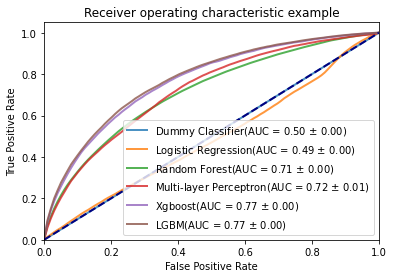

In [21]:
# Affichage de la courbe ROC pour les différents modèles testés / SANS faire de sampling
plot_roc_curve(classifiers_1, var_pipeline, train_set.drop(columns="TARGET"), train_set["TARGET"])

### Equilibrage des données et nouvelle selection modèle de machine learning

On va chercher à équilibrer nos données, on commence par un undersampling puis un oversampling.

#### undersampling

On va chercher à équilibrer nos données à l'aide de RandomUnderSampler en faisant un undersampling.

In [22]:
train_df['TARGET'].value_counts()/len(train_df)*100

0.0    91.927013
1.0     8.072987
Name: TARGET, dtype: float64

In [23]:
from imblearn.under_sampling import RandomUnderSampler

In [24]:
# SEED = nb pour random_state
def rus_undersampler(df, output, SEED=42):
    X = df.drop([output], axis=1)
    y = df[output]
    col_names = pd.concat([X, y], axis=1).columns.tolist()
    rus =RandomUnderSampler(sampling_strategy='not minority',random_state=SEED)
    X_rus, y_rus = rus.fit_resample(X, y)
    rus_array = np.concatenate([X_rus, y_rus.values.reshape(-1, 1)], axis=1)
    df_ = pd.DataFrame(rus_array, columns=col_names)
    rus_cols = df_.columns.tolist()
    org_int_cols = df.dtypes.index[df.dtypes == 'int64'].tolist()
    org_float_cols = df.dtypes.index[df.dtypes == 'float64'].tolist()
    org_uint8_cols = df.dtypes.index[df.dtypes == 'uint8'].tolist()
    try:
        for col in rus_cols:
            if col in org_float_cols:
                df_[col] = df_[col].astype('float64')
            elif col in org_uint8_cols:
                df_[col] = df_[col].astype('uint8')
            elif col in org_int_cols:
                df_[col] = df_[col].astype('int64')
    except:
        raise ValueError
    return df_

In [25]:
train_df_undersample = rus_undersampler(train_df,'TARGET')

In [26]:
train_df_undersample['TARGET'].value_counts()/len(train_df_undersample)*100

0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64

In [27]:
train_df_undersample.shape

(49650, 525)

On a bien 50% pour nos données.   
On passe donc de 307 507 ligne à 49 650.   
Une fois l'équilibrage de nos données on peut faire la selection de nos modèles.   

In [28]:
from sklearn.model_selection import train_test_split
# On split le jeu d'entrainement en entrainement et test
train_set_under, test_set_under = train_test_split(train_df_undersample, test_size=0.2, random_state=42)

Dummy Classifier
Logistic Regression
Random Forest
Multi-layer Perceptron
Xgboost
LGBM


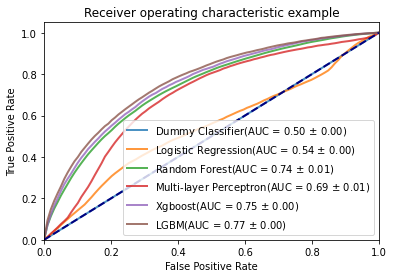

In [29]:
# Affichage de la courbe ROC pour les différents modèles testés / SANS faire d'oversampling
plot_roc_curve(classifiers_1, var_pipeline, train_set_under.drop(columns="TARGET"), train_set_under["TARGET"])

On obtient pas de très bon résultat, on va donc essayer en faisant un oversampling au lieu d'un undersampling.   

#### Oversampling

On va chercher à équilibrer nos données à l'aide de la libairie SMOTE en faisant un oversampling.

In [30]:
train_df['TARGET'].value_counts()/len(train_df)*100

0.0    91.927013
1.0     8.072987
Name: TARGET, dtype: float64

In [31]:
train_df.shape

(307507, 525)

In [32]:
# Oversample and plot imbalanced dataset with SMOTE
# import des librairies
from imblearn.over_sampling import SMOTE

In [33]:
# SEED = nb pour random_state
def smote_oversampler(df, output, SEED=42):
    X = df.drop([output], axis=1)
    y = df[output]
    col_names = pd.concat([X, y], axis=1).columns.tolist()
    smt = SMOTE(random_state=SEED)
    X_smote, y_smote = smt.fit_resample(X, y)
    smote_array = np.concatenate([X_smote, y_smote.values.reshape(-1, 1)], axis=1)
    df_ = pd.DataFrame(smote_array, columns=col_names)
    smote_cols = df_.columns.tolist()
    org_int_cols = df.dtypes.index[df.dtypes == 'int64'].tolist()
    org_float_cols = df.dtypes.index[df.dtypes == 'float64'].tolist()
    org_uint8_cols = df.dtypes.index[df.dtypes == 'uint8'].tolist()
    try:
        for col in smote_cols:
            if col in org_float_cols:
                df_[col] = df_[col].astype('float64')
            elif col in org_uint8_cols:
                df_[col] = df_[col].astype('uint8')
            elif col in org_int_cols:
                df_[col] = df_[col].astype('int64')
    except:
        raise ValueError
    return df_

In [34]:
train_df_oversample = smote_oversampler(train_df,'TARGET')

In [35]:
train_df_oversample['TARGET'].value_counts()/len(train_df_oversample)*100

1.0    50.0
0.0    50.0
Name: TARGET, dtype: float64

In [36]:
train_df_oversample.shape

(565364, 525)

On a bien 50% pour nos données.   
On passe donc de 307 507 ligne à 565 364.   
Une fois l'équilibrage de nos données on peut faire la selection de nos modèles.   

In [37]:
from sklearn.model_selection import train_test_split
# On split le jeu d'entrainement en entrainement et test
train_set_over, test_set_over = train_test_split(train_df_oversample, test_size=0.2, random_state=42)

Dummy Classifier


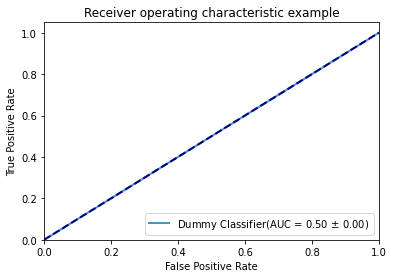

In [38]:
# Affichage de la courbe ROC pour les différents modèles testés
plot_roc_curve(classifiers_2, var_pipeline, train_set_over.drop(columns="TARGET"), train_set_over["TARGET"])

Logistic Regression


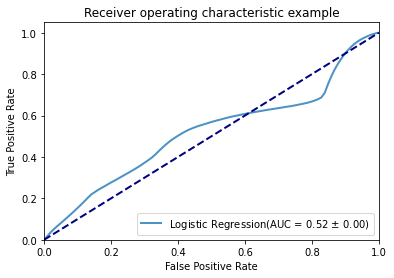

In [39]:
plot_roc_curve(classifiers_3, var_pipeline, train_set_over.drop(columns="TARGET"), train_set_over["TARGET"])

Random Forest


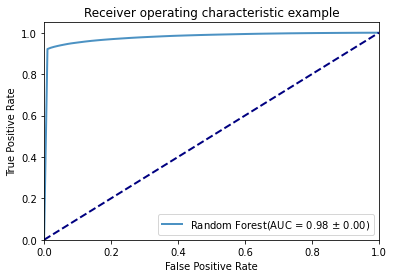

In [40]:
plot_roc_curve(classifiers_4, var_pipeline, train_set_over.drop(columns="TARGET"), train_set_over["TARGET"])

Multi-layer Perceptron


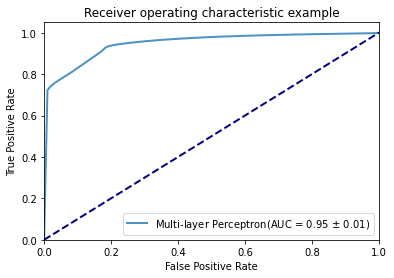

In [41]:
plot_roc_curve(classifiers_5, var_pipeline, train_set_over.drop(columns="TARGET"), train_set_over["TARGET"])

Xgboost


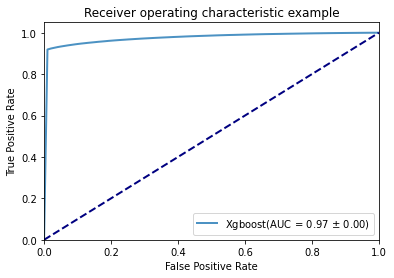

In [42]:
plot_roc_curve(classifiers_6, var_pipeline, train_set_over.drop(columns="TARGET"), train_set_over["TARGET"])

LGBM


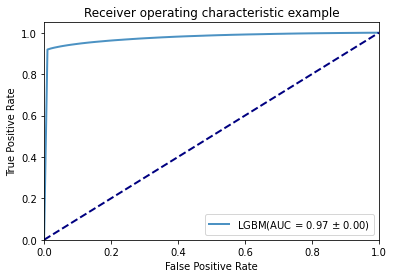

In [43]:
plot_roc_curve(classifiers_7, var_pipeline, train_set_over.drop(columns="TARGET"), train_set_over["TARGET"])

On obtient donc de bon résultats de modèles pour RandomForest, XGBoost et LBGM avec respectivement 0.98, 0.97 et 0.97.

### optimisation des paramètres des modèles avec RandomizedSearchCV

On va donc chercher à optimiser les paramètres de ces 3 modèles afin d'en conserver un seul.

In [44]:
RFC = RandomForestClassifier()
XGBC = XGBClassifier()
LGBMC = LGBMClassifier()

RFC.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [45]:
XGBC.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [46]:
LGBMC.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
X_train = train_set_under.drop(columns="TARGET")
y_train = train_set_under["TARGET"]

X_test = test_set_under.drop(columns="TARGET")
y_test = test_set_under["TARGET"]

#### Optimisation RandomForest

In [ ]:
# n_estimators = nombre d'arbres dans la prévision
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 200)] 

# max_features = nombre maximum de fonctionnalités prises en compte pour diviser un nœud
max_features = ['auto', 'sqrt'] 

# max_depth = nombre maximum de niveaux dans chaque arbre de décision
max_depth = [int(x) for x in np.linspace(10, 100,10)] 
max_depth.append(None) 

# min_samples_split = nombre minimum de points de données placés dans un nœud avant que le nœud ne soit divisé
min_samples_split = [200, 500, 1000] 

# min_samples_leaf = nombre minimal de points de données autorisés dans un nœud feuille
min_samples_leaf = [100, 200, 400] 

# bootstrap = méthode d'échantillonnage des points de données (avec ou sans remplacement)
bootstrap = [True, False]


# Créer la grille aléatoire 
random_grid = {'n_estimators' : n_estimators, 
               'max_features' : max_features, 
               'max_depth' : max_depth, 
               'min_samples_split' : min_samples_split, 
               'min_samples_leaf' : min_samples_leaf, 
               'bootstrap' : bootstrap}

In [ ]:
# Utilisez la grille aléatoire pour rechercher les meilleurs hyperparamètres 
from sklearn.model_selection import RandomizedSearchCV

# Recherche aléatoire de paramètres, en utilisant une validation croisée triple
# recherchez parmi 100 combinaisons différentes et utilisez tous les cœurs disponibles
rf_random = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

#### Optimisation XGBoost

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 200)]
learning_rate = [0.01,0.05,0.1]
booster = ['gbtree', 'gblinear']
gamma = [0, 0.5, 1]
reg_alpha = [0, 0.5, 1]
reg_lambda = [0.5, 1, 5]
base_score = [0.2, 0.5, 1]

# Créer la grille aléatoire 
random_grid = {'n_estimators' : n_estimators, 
               'learning_rate' : learning_rate, 
               'booster' : booster, 
               'gamma' : gamma, 
               'reg_alpha' : reg_alpha, 
               'reg_lambda' : reg_lambda, 
               'base_score' : base_score}

In [ ]:
# Recherche aléatoire de paramètres, en utilisant une validation croisée triple
# recherchez parmi 100 combinaisons différentes et utilisez tous les cœurs disponibles
XGB_random = RandomizedSearchCV(estimator = XGBC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
XGB_random.fit(X_train, y_train)

In [ ]:
XGB_random.best_params_

In [ ]:
base_model = XGBClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = XGB_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

#### Optimisation LGBM

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 200)]
learning_rate = [int(x) for x in np.linspace(0,1,1)]
max_depth = [int(x) for x in np.linspace(10,200,10)]
num_leaves = [int(x) for x in np.linspace(20,300,20)]
boosting_type = ['gbdt', 'dart', 'goss']


# Créer la grille aléatoire 
random_grid = {'n_estimators' : n_estimators, 
               'learning_rate' : learning_rate, 
               'num_leaves' : num_leaves, 
               'max_depth' : max_depth, 
               'boosting_type' : boosting_type}

In [ ]:
# Recherche aléatoire de paramètres, en utilisant une validation croisée triple
# recherchez parmi 100 combinaisons différentes et utilisez tous les cœurs disponibles
LGBM_random = RandomizedSearchCV(estimator = LGBMC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
LGBM_random.fit(X_train, y_train)

In [ ]:
LGBM_random.best_params_

In [ ]:
base_model = LGBMClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = LGBM_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

### optimisation des paramètres des modèles avec GridSearchCV

#### RandomForest

In [ ]:
# n_estimators = nombre d'arbres dans la prévision
n_estimators = [int(x) for x in np.linspace(200,2000,200)] 

# max_features = nombre maximum de fonctionnalités prises en compte pour diviser un nœud
max_features = ['auto', 'sqrt'] 

# max_depth = nombre maximum de niveaux dans chaque arbre de décision
max_depth = [int(x) for x in np.linspace(10, 100,10)] 
max_depth.append(None) 

params = {
    'n_estimators' : n_estimators, 
    'max_features' : max_features, 
    'max_depth' : max_depth
}

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
import time

time1 = time.time()

gs1 = GridSearchCV(RFC, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs1.fit(X_train, y_train)

time2 = np.round(time.time() - time1,0)
print("time : ", time2)
    
print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)

#### XGBoost

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 200)]
learning_rate = [0.01,0.05,0.1]
booster = ['gbtree', 'gblinear']

# Créer la grille aléatoire 
params = {'n_estimators' : n_estimators, 
               'learning_rate' : learning_rate, 
               'booster' : booster}

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

time1 = time.time()

gs2 = GridSearchCV(XGBC, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs1.fit(X_train, y_train)

time2 = np.round(time.time() - time1,0)
print("time : ", time2)
print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)

#### LGBM

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 200)]
learning_rate = [int(x) for x in np.linspace(0,1,1)]
max_depth = [int(x) for x in np.linspace(10,200,10)]


# Créer la grille aléatoire 
params = {'n_estimators' : n_estimators, 
               'learning_rate' : learning_rate,
               'max_depth' : max_depth}

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

time1 = time.time()

gs2 = GridSearchCV(XGBC, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs1.fit(X_train, y_train)

time2 = np.round(time.time() - time1,0)
print("time : ", time2)
print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)

### Fonction Coût

recall = maximise le nombre de Vrai Positif   
precision = minimise le nombre de Faux Positif   

En une phrase :   
- Plus le recall est haut, plus le modèle repère de positif   
- Plus la precision est haute, moins le modèle se trompe sur les positifs   

Positif = non remboursement
négatif = remboursement (solvable)

92% bon clients -> 0

faux négatif = pret non remboursé (accordé)   
vrai négatif = pret remboursé (accordé)   
faux positif = remboursement possible (non accordé)   
vrai positif = remboursement impossible (non accordé)   

In [47]:
# Prediction on oversampling
X_train = train_set_over.drop(columns="TARGET")
y_train = train_set_over["TARGET"]

X_test = test_set_over.drop(columns="TARGET")
y_test = test_set_over["TARGET"]

# Prédiction with RandomForest
RF = RFC.fit(X_train, y_train)
y_predict_RF = RF.predict(X_test)

prob_RF = RF.predict_proba(X_test)
fper_RF, tper_RF, thresholds_RF = roc_curve(y_test, prob_RF[:, 1])

# Prédiction with XGBoost
XGB = XGBC.fit(X_train, y_train)
y_predict_XGB = XGB.predict(X_test)

prob_XGB = XGB.predict_proba(X_test)
fper_XGB, tper_XGB, thresholds_XGB = roc_curve(y_test, prob_XGB[:, 1])

# Prédiction with LGBM
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
import re
X_train2 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test2 = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

LGBM = LGBMC.fit(X_train2, y_train)
y_predict_LGBM = LGBM.predict(X_test2)

prob_LGBM = LGBM.predict_proba(X_test2)
fper_LGBM, tper_LGBM, thresholds_LGBM = roc_curve(y_test, prob_LGBM[:, 1])

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

print('----------------------------')
print('RandomForest :')
print("Mean squared error : {:.2f}".format(mean_squared_error(y_test, y_predict_RF)))
print("Median absolute error : {:.2f}".format(median_absolute_error(y_test, y_predict_RF)))
print("r2_score : {:.2f}".format(r2_score(y_test, y_predict_RF)))

print('----------------------------')
print('XGBoost :')
print("Mean squared error : {:.2f}".format(mean_squared_error(y_test, y_predict_XGB)))
print("Median absolute error : {:.2f}".format(median_absolute_error(y_test, y_predict_XGB)))
print("r2_score : {:.2f}".format(r2_score(y_test, y_predict_XGB)))

print('----------------------------')
print('LGBM :')
print("Mean squared error : {:.2f}".format(mean_squared_error(y_test, y_predict_LGBM)))
print("Median absolute error : {:.2f}".format(median_absolute_error(y_test, y_predict_LGBM)))
print("r2_score : {:.2f}".format(r2_score(y_test, y_predict_LGBM)))
print('----------------------------')

----------------------------
RandomForest :
Mean squared error : 0.04
Median absolute error : 0.00
r2_score : 0.82
----------------------------
XGBoost :
Mean squared error : 0.04
Median absolute error : 0.00
r2_score : 0.82
----------------------------
LGBM :
Mean squared error : 0.04
Median absolute error : 0.00
r2_score : 0.82
----------------------------


Les valeurs des poids sont les suivantes : (f=false, t=true, n=negatif, p=positif)
- fn_value = -10 
- tp_value = 0 
- tn_value = 1 
- fp_value = 0

De ce fait, les prêts accordés aux individus qui ne sont finalement pas solvables sont dotés d'une pénalisation négative de -10, alors que les prêts accordés aux individus finalement solvables rapportent 1. 

Objectif

fonc(model,y_true, y_pred)
courbe ROC, Temps, fbeta (precision/recall, matrice confusion)

fbeta_score(y_true, y_pred, average='binary', beta=10)

In [49]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def fonction_result(model, fper_model, tper_model, prob_model, y_pred, y_true=y_test):
    # start timer
    time1 = time.time() 
    
    # affichage courbe ROC
    plot_roc_curve(fper_model, tper_model) 
    
    # fbeta_score
    fbeta = fbeta_score(y_true, y_pred, average='binary', beta=10)
    print('fbeta score :', fbeta)
    
    # precision / recall
    average_precision = average_precision_score(y_test, prob_model[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test, prob_model[:, 1])
    auc_precision_recall = auc(recall, precision)
    print('\naverage precision score :', average_precision)
    print('auc precision recall :', auc_precision_recall)
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
    # matrice confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('\nTrue Positive :',tp,'\nFalse Positive :',fp,'\nTrue negatif :',tn,'\nFalse negatif :',fn)
    pourcent_p = fp/tp*100
    pourcent_n = fn/tn*100
    print("Pourcentage d'erreur en Positif :",round(pourcent_p,2),"%")
    print("Pourcentage d'erreur en Négatif :",round(pourcent_n,2),"%")
    
    #end timer
    time2 = np.round(time.time() - time1,0) 
    print("\ntime : ", time2)

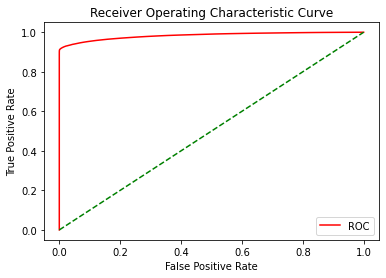

fbeta score : 0.9142258643089574

average precision score : 0.9871457793440216
auc precision recall : 0.9876341435083525

True Positive : 51815 
False Positive : 98 
True negatif : 56251 
False negatif : 4909
Pourcentage d'erreur en Positif : 0.19 %
Pourcentage d'erreur en Négatif : 8.73 %

time :  6.0


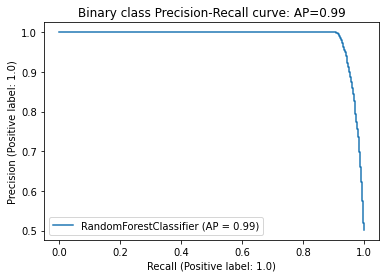

In [50]:
fonction_result(RFC, fper_RF, tper_RF, prob_RF, y_predict_RF, y_test)

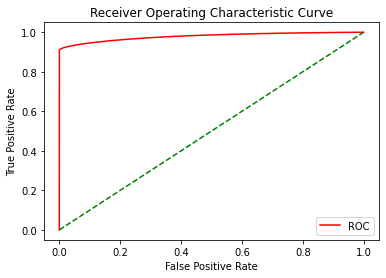

fbeta score : 0.9180777277364964

average precision score : 0.9849500769778476
auc precision recall : 0.9849499795717834

True Positive : 52038 
False Positive : 391 
True negatif : 55958 
False negatif : 4686
Pourcentage d'erreur en Positif : 0.75 %
Pourcentage d'erreur en Négatif : 8.37 %

time :  1.0


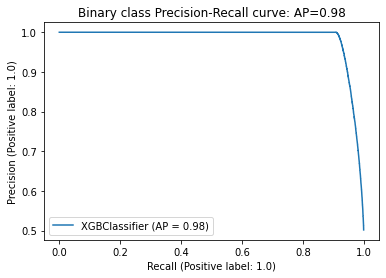

In [51]:
fonction_result(XGBC, fper_XGB, tper_XGB, prob_XGB, y_predict_XGB, y_test)

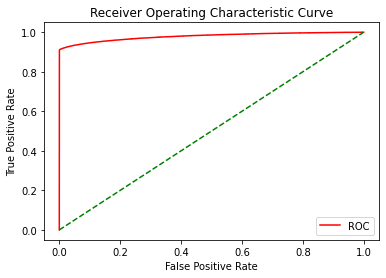

fbeta score : 0.9137287983995337

average precision score : 0.984975988450193
auc precision recall : 0.9849758901587705

True Positive : 51787 
False Positive : 145 
True negatif : 56204 
False negatif : 4937
Pourcentage d'erreur en Positif : 0.28 %
Pourcentage d'erreur en Négatif : 8.78 %

time :  1.0


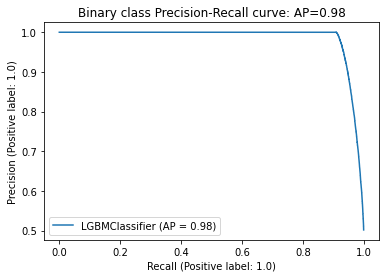

In [52]:
fonction_result(LGBMC, fper_LGBM, tper_LGBM, prob_LGBM, y_predict_LGBM, y_test)

In [53]:
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=5)
kfold = strtfdKFold.split(X_train, y_train)

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores = []
pipeline = make_pipeline(StandardScaler(), RFC)

for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
    
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [181066 180766], Accuracy: 0.954
Fold:  2, Training/Test Split Distribution: [181067 180766], Accuracy: 0.956
Fold:  3, Training/Test Split Distribution: [181067 180766], Accuracy: 0.955
Fold:  4, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955
Fold:  5, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955


Cross-Validation accuracy: 0.955 +/- 0.000


In [55]:
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=5)
kfold = strtfdKFold.split(X_train, y_train)

Fold:  1, Training/Test Split Distribution: [181066 180766], Accuracy: 0.954


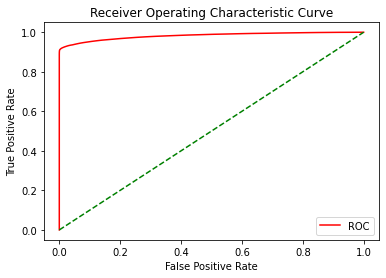

fbeta score : 0.9133118843888265

average precision score : 0.9864650956615351
auc precision recall : 0.9869606424132478


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51763 
False Positive : 128 
True negatif : 56221 
False negatif : 4961
Pourcentage d'erreur en Positif : 0.25 %
Pourcentage d'erreur en Négatif : 8.82 %
Fold:  2, Training/Test Split Distribution: [181067 180766], Accuracy: 0.956


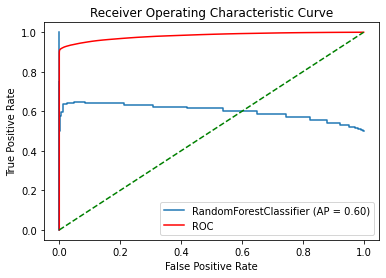

fbeta score : 0.9135366296782849

average precision score : 0.986527608097508
auc precision recall : 0.987022134958578


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51776 
False Positive : 144 
True negatif : 56205 
False negatif : 4948
Pourcentage d'erreur en Positif : 0.28 %
Pourcentage d'erreur en Négatif : 8.8 %
Fold:  3, Training/Test Split Distribution: [181067 180766], Accuracy: 0.955


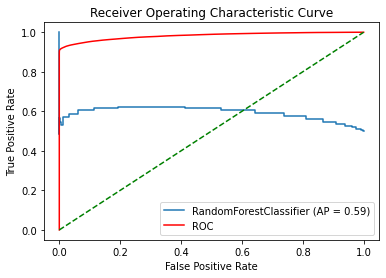

fbeta score : 0.9134512819204856

average precision score : 0.986438540431905
auc precision recall : 0.9869299109843347


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51771 
False Positive : 131 
True negatif : 56218 
False negatif : 4953
Pourcentage d'erreur en Positif : 0.25 %
Pourcentage d'erreur en Négatif : 8.81 %
Fold:  4, Training/Test Split Distribution: [181066 180767], Accuracy: 0.954


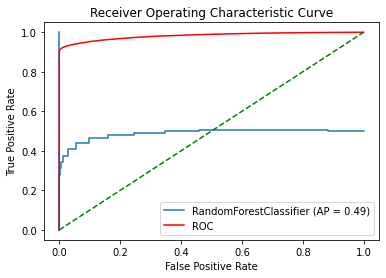

fbeta score : 0.913448888312789

average precision score : 0.9865841660529506
auc precision recall : 0.9870750160037751


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51771 
False Positive : 146 
True negatif : 56203 
False negatif : 4953
Pourcentage d'erreur en Positif : 0.28 %
Pourcentage d'erreur en Négatif : 8.81 %
Fold:  5, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955


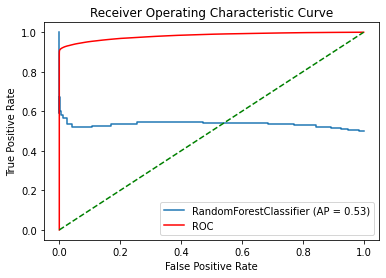

fbeta score : 0.9132734053058964

average precision score : 0.9865598284592215
auc precision recall : 0.987051042063494


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51761 
False Positive : 150 
True negatif : 56199 
False negatif : 4963
Pourcentage d'erreur en Positif : 0.29 %
Pourcentage d'erreur en Négatif : 8.83 %


Cross-Validation accuracy: 0.955 +/- 0.000


fbeta accuracy: 0.913 +/- 0.000


average_precision accuracy: 0.987 +/- 0.000


auc_precision_recall accuracy: 0.987 +/- 0.000


True negatif accuracy: 56209.200 +/- 8.681


True Positive accuracy: 139.800 +/- 8.681


False negatif accuracy: 4955.600 +/- 5.571


False Positive accuracy: 51768.400 +/- 5.571


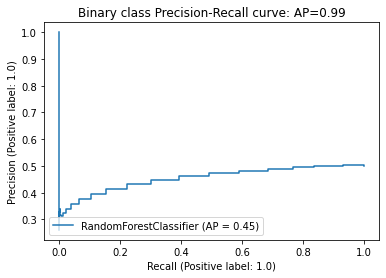

In [56]:
scores = []
fbetas = []
average_precisions = []
auc_precision_recalls = []
tns = []
fps = []
fns = []
tps = []

pipeline = make_pipeline(StandardScaler(), RFC)

for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
    # Prédiction with RandomForest
    y_predict = pipeline.predict(X_test)

    prob = pipeline.predict_proba(X_test)
    fper, tper, thresholds = roc_curve(y_test, prob[:, 1])
    
    # affichage courbe ROC
    plot_roc_curve(fper, tper) 
    
    # fbeta_score
    fbeta = fbeta_score(y_test, y_predict, average='binary', beta=10)
    print('fbeta score :', fbeta)
    fbetas.append(fbeta)
    
    # precision / recall
    average_precision = average_precision_score(y_test, prob[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test, prob[:, 1])
    auc_precision_recall = auc(recall, precision)
    print('\naverage precision score :', average_precision)
    average_precisions.append(average_precision)
    print('auc precision recall :', auc_precision_recall)
    auc_precision_recalls.append(auc_precision_recall)
    disp = plot_precision_recall_curve(RFC, X_test, y_test)
    disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
    # matrice confusion
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print('\nTrue Positive :',tp,'\nFalse Positive :',fp,'\nTrue negatif :',tn,'\nFalse negatif :',fn)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    pourcent_p = fp/tp*100
    pourcent_n = fn/tn*100
    print("Pourcentage d'erreur en Positif :",round(pourcent_p,2),"%")
    print("Pourcentage d'erreur en Négatif :",round(pourcent_n,2),"%")

print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))
print('\n\nfbeta accuracy: %.3f +/- %.3f' %(np.mean(fbetas), np.std(fbetas)))
print('\n\naverage_precision accuracy: %.3f +/- %.3f' %(np.mean(average_precisions), np.std(average_precisions)))
print('\n\nauc_precision_recall accuracy: %.3f +/- %.3f' %(np.mean(auc_precision_recalls), np.std(auc_precision_recalls)))
print('\n\nTrue negatif accuracy: %.3f +/- %.3f' %(np.mean(tns), np.std(tns)))
print('\n\nTrue Positive accuracy: %.3f +/- %.3f' %(np.mean(fps), np.std(fps)))
print('\n\nFalse negatif accuracy: %.3f +/- %.3f' %(np.mean(fns), np.std(fns)))
print('\n\nFalse Positive accuracy: %.3f +/- %.3f' %(np.mean(tps), np.std(tps)))

Fold:  1, Training/Test Split Distribution: [181066 180766], Accuracy: 0.954


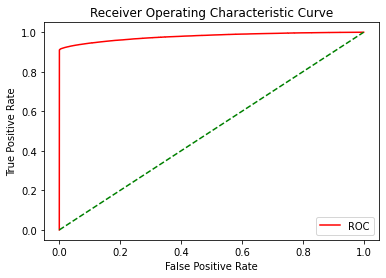

fbeta score : 0.9185062744250693

average precision score : 0.9846917356258313
auc precision recall : 0.9846916364153857


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 52063 
False Positive : 444 
True negatif : 55905 
False negatif : 4661
Pourcentage d'erreur en Positif : 0.85 %
Pourcentage d'erreur en Négatif : 8.34 %
Fold:  2, Training/Test Split Distribution: [181067 180766], Accuracy: 0.955


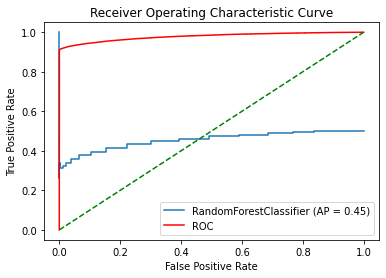

fbeta score : 0.9175277666760759

average precision score : 0.9846386897148469
auc precision recall : 0.9846385908856312


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 52007 
False Positive : 441 
True negatif : 55908 
False negatif : 4717
Pourcentage d'erreur en Positif : 0.85 %
Pourcentage d'erreur en Négatif : 8.44 %
Fold:  3, Training/Test Split Distribution: [181067 180766], Accuracy: 0.955


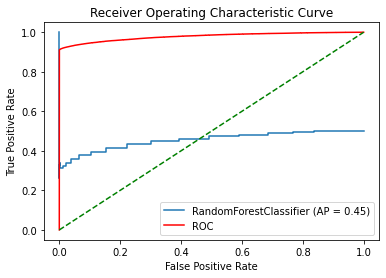

fbeta score : 0.9178280079499083

average precision score : 0.9846778631868395
auc precision recall : 0.9846777642677882


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 52024 
False Positive : 422 
True negatif : 55927 
False negatif : 4700
Pourcentage d'erreur en Positif : 0.81 %
Pourcentage d'erreur en Négatif : 8.4 %
Fold:  4, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955


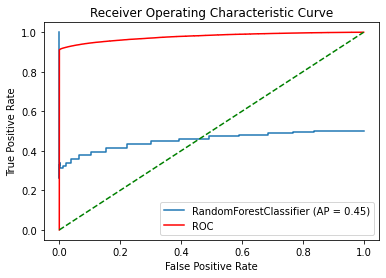

fbeta score : 0.9183818164572981

average precision score : 0.9844625908320743
auc precision recall : 0.9844624908381134


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 52056 
False Positive : 457 
True negatif : 55892 
False negatif : 4668
Pourcentage d'erreur en Positif : 0.88 %
Pourcentage d'erreur en Négatif : 8.35 %
Fold:  5, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955


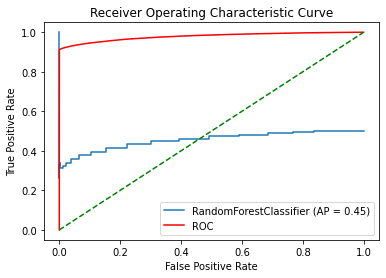

fbeta score : 0.9178108465157909

average precision score : 0.984846184639395
auc precision recall : 0.9848460864161936


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 52023 
False Positive : 420 
True negatif : 55929 
False negatif : 4701
Pourcentage d'erreur en Positif : 0.81 %
Pourcentage d'erreur en Négatif : 8.41 %


Cross-Validation accuracy: 0.955 +/- 0.000


fbeta accuracy: 0.918 +/- 0.000


average_precision accuracy: 0.985 +/- 0.000


auc_precision_recall accuracy: 0.985 +/- 0.000


True negatif accuracy: 55912.200 +/- 13.991


True Positive accuracy: 436.800 +/- 13.991


False negatif accuracy: 4689.400 +/- 21.322


False Positive accuracy: 52034.600 +/- 21.322


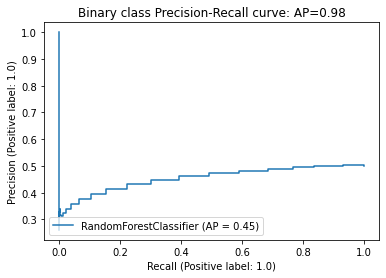

In [57]:
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=5)
kfold = strtfdKFold.split(X_train, y_train)

scores = []
fbetas = []
average_precisions = []
auc_precision_recalls = []
tns = []
fps = []
fns = []
tps = []

pipeline = make_pipeline(StandardScaler(), XGBC)

for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
    # Prédiction with RandomForest
    y_predict = pipeline.predict(X_test)

    prob = pipeline.predict_proba(X_test)
    fper, tper, thresholds = roc_curve(y_test, prob[:, 1])
    
    # affichage courbe ROC
    plot_roc_curve(fper, tper) 
    
    # fbeta_score
    fbeta = fbeta_score(y_test, y_predict, average='binary', beta=10)
    print('fbeta score :', fbeta)
    fbetas.append(fbeta)
    
    # precision / recall
    average_precision = average_precision_score(y_test, prob[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test, prob[:, 1])
    auc_precision_recall = auc(recall, precision)
    print('\naverage precision score :', average_precision)
    average_precisions.append(average_precision)
    print('auc precision recall :', auc_precision_recall)
    auc_precision_recalls.append(auc_precision_recall)
    disp = plot_precision_recall_curve(RFC, X_test, y_test)
    disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
    # matrice confusion
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print('\nTrue Positive :',tp,'\nFalse Positive :',fp,'\nTrue negatif :',tn,'\nFalse negatif :',fn)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    pourcent_p = fp/tp*100
    pourcent_n = fn/tn*100
    print("Pourcentage d'erreur en Positif :",round(pourcent_p,2),"%")
    print("Pourcentage d'erreur en Négatif :",round(pourcent_n,2),"%")

print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))
print('\n\nfbeta accuracy: %.3f +/- %.3f' %(np.mean(fbetas), np.std(fbetas)))
print('\n\naverage_precision accuracy: %.3f +/- %.3f' %(np.mean(average_precisions), np.std(average_precisions)))
print('\n\nauc_precision_recall accuracy: %.3f +/- %.3f' %(np.mean(auc_precision_recalls), np.std(auc_precision_recalls)))
print('\n\nTrue negatif accuracy: %.3f +/- %.3f' %(np.mean(tns), np.std(tns)))
print('\n\nTrue Positive accuracy: %.3f +/- %.3f' %(np.mean(fps), np.std(fps)))
print('\n\nFalse negatif accuracy: %.3f +/- %.3f' %(np.mean(fns), np.std(fns)))
print('\n\nFalse Positive accuracy: %.3f +/- %.3f' %(np.mean(tps), np.std(tps)))

Fold:  1, Training/Test Split Distribution: [181066 180766], Accuracy: 0.955


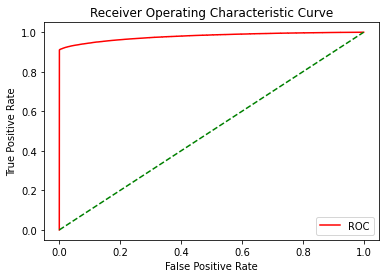

fbeta score : 0.9138850398333574

average precision score : 0.9849959050694856
auc precision recall : 0.9849958066698241


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51796 
False Positive : 152 
True negatif : 56197 
False negatif : 4928
Pourcentage d'erreur en Positif : 0.29 %
Pourcentage d'erreur en Négatif : 8.77 %
Fold:  2, Training/Test Split Distribution: [181067 180766], Accuracy: 0.956


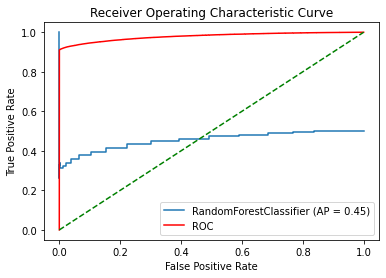

fbeta score : 0.9139875504182208

average precision score : 0.9849192526718581
auc precision recall : 0.9849191538287799


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51802 
False Positive : 167 
True negatif : 56182 
False negatif : 4922
Pourcentage d'erreur en Positif : 0.32 %
Pourcentage d'erreur en Négatif : 8.76 %
Fold:  3, Training/Test Split Distribution: [181067 180766], Accuracy: 0.956


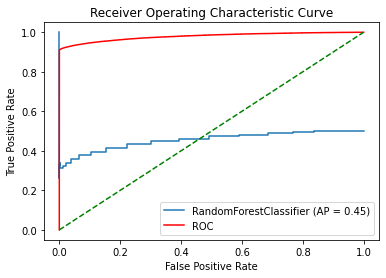

fbeta score : 0.9140250735672402

average precision score : 0.9849574186813209
auc precision recall : 0.9849573202276768


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51804 
False Positive : 151 
True negatif : 56198 
False negatif : 4920
Pourcentage d'erreur en Positif : 0.29 %
Pourcentage d'erreur en Négatif : 8.75 %
Fold:  4, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955


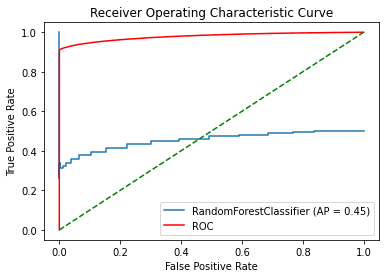

fbeta score : 0.9136400996797007

average precision score : 0.9849740297461291
auc precision recall : 0.9849739315090629


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51782 
False Positive : 153 
True negatif : 56196 
False negatif : 4942
Pourcentage d'erreur en Positif : 0.3 %
Pourcentage d'erreur en Négatif : 8.79 %
Fold:  5, Training/Test Split Distribution: [181066 180767], Accuracy: 0.955


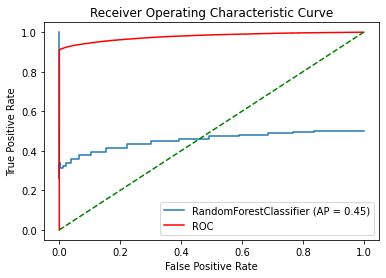

fbeta score : 0.9140064716393672

average precision score : 0.9849846908290555
auc precision recall : 0.9849845923630643


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



True Positive : 51803 
False Positive : 158 
True negatif : 56191 
False negatif : 4921
Pourcentage d'erreur en Positif : 0.31 %
Pourcentage d'erreur en Négatif : 8.76 %


Cross-Validation accuracy: 0.955 +/- 0.000


fbeta accuracy: 0.914 +/- 0.000


average_precision accuracy: 0.985 +/- 0.000


auc_precision_recall accuracy: 0.985 +/- 0.000


True negatif accuracy: 56192.800 +/- 5.913


True Positive accuracy: 156.200 +/- 5.913


False negatif accuracy: 4926.600 +/- 8.188


False Positive accuracy: 51797.400 +/- 8.188


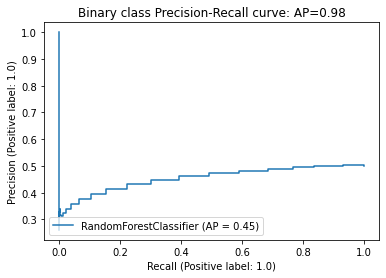

In [58]:
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=5)
kfold = strtfdKFold.split(X_train, y_train)

scores = []
fbetas = []
average_precisions = []
auc_precision_recalls = []
tns = []
fps = []
fns = []
tps = []

pipeline = make_pipeline(StandardScaler(), LGBMC)

for k, (train, test) in enumerate(kfold):
    X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
    # Prédiction with RandomForest
    y_predict = pipeline.predict(X_test)

    prob = pipeline.predict_proba(X_test)
    fper, tper, thresholds = roc_curve(y_test, prob[:, 1])
    
    # affichage courbe ROC
    plot_roc_curve(fper, tper) 
    
    # fbeta_score
    fbeta = fbeta_score(y_test, y_predict, average='binary', beta=10)
    print('fbeta score :', fbeta)
    fbetas.append(fbeta)
    
    # precision / recall
    average_precision = average_precision_score(y_test, prob[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test, prob[:, 1])
    auc_precision_recall = auc(recall, precision)
    print('\naverage precision score :', average_precision)
    average_precisions.append(average_precision)
    print('auc precision recall :', auc_precision_recall)
    auc_precision_recalls.append(auc_precision_recall)
    disp = plot_precision_recall_curve(RFC, X_test, y_test)
    disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
    # matrice confusion
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print('\nTrue Positive :',tp,'\nFalse Positive :',fp,'\nTrue negatif :',tn,'\nFalse negatif :',fn)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    pourcent_p = fp/tp*100
    pourcent_n = fn/tn*100
    print("Pourcentage d'erreur en Positif :",round(pourcent_p,2),"%")
    print("Pourcentage d'erreur en Négatif :",round(pourcent_n,2),"%")

print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))
print('\n\nfbeta accuracy: %.3f +/- %.3f' %(np.mean(fbetas), np.std(fbetas)))
print('\n\naverage_precision accuracy: %.3f +/- %.3f' %(np.mean(average_precisions), np.std(average_precisions)))
print('\n\nauc_precision_recall accuracy: %.3f +/- %.3f' %(np.mean(auc_precision_recalls), np.std(auc_precision_recalls)))
print('\n\nTrue negatif accuracy: %.3f +/- %.3f' %(np.mean(tns), np.std(tns)))
print('\n\nTrue Positive accuracy: %.3f +/- %.3f' %(np.mean(fps), np.std(fps)))
print('\n\nFalse negatif accuracy: %.3f +/- %.3f' %(np.mean(fns), np.std(fns)))
print('\n\nFalse Positive accuracy: %.3f +/- %.3f' %(np.mean(tps), np.std(tps)))

Un faux négatif est environ 10 fois plus coûteux qu’un faux positif

refaire en 5 sample
k-fold (stratified k-fold?)

- Features importances (shape/lime)

après

- Flask (dashboard)

### Features importances

<AxesSubplot:>

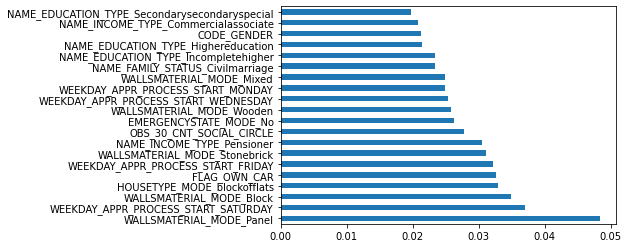

In [59]:
# Faire sortir les variables les plus importantes 
model = XGBC
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance

(pd.Series(importance, index=X_train.columns)
   .nlargest(20)
   .plot(kind='barh')) 

In [60]:
# on redéfini notre meilleur modèle
#scaler = StandardScaler().fit(X_train)
#rescaled_X_train = scaler.transform(X_train)
#model = RFC
#model.fit(rescaled_X_train, y_train)

model = XGBC
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
# 3 Façon de save le modèle

# ----------- PICKLE -----------

import pickle

# enregistrer le modèle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
# charger le modèle
#with open('model.pkl', 'rb') as file:
#    model = pickle.load(file)

# ----------- SAVEMODEL -----------

model.save_model("model.bin")

# ----------- JOBLIB -----------

from joblib import dump, load

# enregistrer le modèle
dump(model, 'model.joblib')

# charger le modèle
#model = load('model.joblib')


['model.joblib']

In [ ]:
import pickle

# save the model to disk
filename = 'model.pkl'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [62]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=y_train, verbose=True, mode='regression')

# observation de 3 instances pour la prédiction
j = [5,25,50]
for i in j:
    print("\nObservation de la",i,"ème instance pour la prédiction :\n")
    exp = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=6)
    print(exp)
    # Show the predictions
    exp.show_in_notebook(show_table=True)
    print(exp.as_list())


Observation de la 5 ème instance pour la prédiction :

Intercept 0.07667627657295996
Prediction_local [0.11981521]
Right: 0.9936332


[('WEEKDAY_APPR_PROCESS_START_WEDNESDAY <= 0.00', -0.05523989751809811), ('WEEKDAY_APPR_PROCESS_START_MONDAY > 0.00', 0.041224938252395996), ('0.00 < NAME_FAMILY_STATUS_Married <= 1.00', 0.03724466411884708), ('WEEKDAY_APPR_PROCESS_START_TUESDAY <= 0.00', -0.03415539058851206), ('NAME_EDUCATION_TYPE_Highereducation > 0.00', 0.030747260290871232), ('0.00 < NAME_INCOME_TYPE_Working <= 1.00', 0.0233173544425268)]

Observation de la 25 ème instance pour la prédiction :

Intercept 0.1632884139184368
Prediction_local [0.02381182]
Right: 0.0011891127


[('WEEKDAY_APPR_PROCESS_START_WEDNESDAY <= 0.00', -0.04823649381237244), ('WEEKDAY_APPR_PROCESS_START_FRIDAY <= 0.00', -0.0394675805994677), ('WEEKDAY_APPR_PROCESS_START_THURSDAY <= 0.00', -0.03475620829462628), ('0.00 < NAME_FAMILY_STATUS_Married <= 1.00', 0.033225014921677606), ('NAME_INCOME_TYPE_Commercialassociate <= 0.00', -0.029926006835568203), ('NAME_INCOME_TYPE_Working <= 0.00', -0.020315320569998817)]

Observation de la 50 ème instance pour la prédiction :

Intercept 0.1454731569538737
Prediction_local [0.087345]
Right: 0.85630405


[('WEEKDAY_APPR_PROCESS_START_SUNDAY <= 0.00', -0.05953841424552797), ('WEEKDAY_APPR_PROCESS_START_WEDNESDAY <= 0.00', -0.0588226994060739), ('WEEKDAY_APPR_PROCESS_START_MONDAY <= 0.00', -0.036947792584821317), ('WEEKDAY_APPR_PROCESS_START_SATURDAY > 0.00', 0.03681651127108456), ('0.00 < NAME_FAMILY_STATUS_Married <= 1.00', 0.034738611036803355), ('0.00 < NAME_INCOME_TYPE_Working <= 1.00', 0.02562562363768789)]


In [63]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')